# 1. Google Drive Mount(colab을 구글 드라이브에 연결하기)

In [ ]:
# 1. Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 구글 드라이브에 업로드한 airbnb 파일 확인하기

In [ ]:
# 2. 업로드된 파일 확인
import os

# 경로 설정
data_path = '/content/drive/MyDrive/airbnb_datasets'

# 파일 리스트 확인
files = os.listdir(data_path) # listdir: data_path 디렉토리 안에 있는 모든 파일과 하위 디렉토리의 이름을 리스트로 반환하는 함수. # cf.) os.scandir(path) : 파일 정보 객체 반환 (더 많은 정보)

print(f"총 파일 개수: {len(files)}")
print("\n파일 목록:")
for f in sorted(files): # 파일 이름을 알파벳 순으로 오름차순 정렬.
  file_path = os.path.join(data_path,f) # os.path.join(): 경로를 OS에 맞게 결합(Windows: \, Linux/Mac: /). ex.) '/content/drive/MyDrive/airbnb_datasets' + 'calendar_London.csv.gz'
  size_mb = os.path.getsize(file_path) / (1024*1024) # 파일 크기를 바이트 -> 메가바이트로 변환. # 1 MB = 1024 KB = 1024 * 1024 bytes
  print(f"  - {f:<30} {size_mb:>8.2f} MB") # {f:<30}: f를 왼쪽 정렬, 총 30칸 차지 (파일명 깔끔하게 정렬). {size_mb:>8.2f}: size_mb를 오른쪽 정렬, 8칸 차지, 소수점 2자리까지

총 파일 개수: 12

파일 목록:
  - calendar_London.csv.gz            77.77 MB
  - calendar_Lyon.csv.gz               7.96 MB
  - calendar_Madrid.csv.gz            20.63 MB
  - calendar_New_York.csv.gz           0.40 MB
  - listings_London.csv.gz            48.06 MB
  - listings_Lyon.csv.gz               4.50 MB
  - listings_Madrid.csv.gz            11.75 MB
  - listings_New_York.csv.gz           0.22 MB
  - reviews_London.csv.gz            246.09 MB
  - reviews_Lyon.csv.gz               39.94 MB
  - reviews_Madrid.csv.gz            137.77 MB
  - reviews_New_York.csv.gz            2.53 MB


# 3. Spark 초기화

※SparkSession

-> Spark 어플리케이션의 진입점

-> Spark의 모든 기능에 접근하는 메인 객체

->DataFrame,SQL,Streaming 등 모든 작업의 시작점



```
# 각 설정 설명:
# ============================================================
# .appName("Airbnb Analysis")
#   - Spark UI에 표시될 애플리케이션 이름
#   - 로그 추적, 모니터링할 때 식별용
#
# .master("local[*]")
#   - 실행 모드: local = 로컬 머신에서 실행 (단일 JVM)
#   - [*] = 사용 가능한 모든 CPU 코어 사용
#   - Colab 기본: 2코어, 따라서 [*] = [2]와 동일
#
# .config("spark.driver.memory", "8g")
#   - Driver 프로그램에 할당할 메모리
#   - Driver: Spark 작업을 조율하는 메인 프로세스
#   - "8g" = 8GB (Colab 무료 버전: 12-13GB RAM 중 8GB 할당)
#
# .config("spark.sql.shuffle.partitions", "200")
#   - Shuffle 작업 시 생성될 파티션 개수
#   - Shuffle: JOIN, GROUP BY 등에서 데이터 재분배
#   - 기본값 200 → 대용량 데이터에 적합
#   - 작은 데이터면 50-100으로 줄이면 더 빠름
#
# .getOrCreate()
#   - 기존 SparkSession이 있으면 재사용, 없으면 새로 생성
#   - 같은 셀 여러 번 실행해도 안전
# ============================================================
```



In [ ]:
# PySpark 설치
!pip install -q PySpark # !: 셸 명령어 실행 (Colab/Jupyter에서만 사용 가능). # -q: quiet mode

In [ ]:
import pyspark
print(f"PySpark 버전: {pyspark.__version__}")

PySpark 버전: 4.0.1


In [ ]:
# 3. PySpark 환경 설정 및 SparkSession 생성
from pyspark.sql import SparkSession

# 밑에와 같이 해도 되나, \ 오류가 좀 많이 나서 그 다음으로 코드 설정.

# spark = SparkSession.builder \
#     .appname("Airbnb Analysis") \
#     .master("local[*]") \
#     .config("spark.driver.memory", "8g") \
#     .config("spark.sql.shuffle.partitions", "200") \
#     .getOrCreate()

spark = (SparkSession.builder
    .appName("Airbnb Analysis")  # 앱 이름
    .master("local[*]")  # 로컬 모드, 모든 코어 사용
    .config("spark.driver.memory", "8g")  # Driver 메모리 8GB
    .config("spark.sql.shuffle.partitions", "200")  # Shuffle 파티션 수
    .getOrCreate())  # 기존 세션 재사용 또는 신규 생성



In [ ]:
print("✅ Spark 시작 완료!")
print(f"Spark 버전: {spark.version}")
print(f"사용 가능한 코어: {spark.sparkContext.defaultParallelism}")

✅ Spark 시작 완료!
Spark 버전: 4.0.1
사용 가능한 코어: 2


# 4. 본격적인 데이터 로드하기!


## 4-1. London Listings 로딩(가장 작은 파일부터)

In [ ]:
# 4-1. 첫 번째 데이터 로딩 - London Listings
# 가장 작은 파일(48MB)부터 시작해서 Spark 잘 작동하는지 확인.

# 파일 경로 설정
listings_path_London = os.path.join(data_path,'listings_London.csv.gz') # Spark는 gz(압축 파일) 읽을 수 있음. 압축 해제 필요 x -> 메모리 공간 확보 o

# Spark DataFrame으로 로딩
df_listings_London = (spark.read
    .option("header", "true") # 첫 번째 행을 컬럼명으로 사용
    .option("inferSchema", "true") # 데이터 타입 자동 추론(Int,String 등). 비활성시 모든 칼럼이 String으로 읽힘.
    .option("compression", 'gzip') # .gz 압축 파일 자동 해제
    .csv(listings_path_London)) # CSV 파일 읽기

print("✅ London Listings 로딩 완료!")
print(f"총 행(row) 수: {df_listings_London.count():,}")  # :, 는 천 단위 콤마
print(f"총 열(column) 수: {len(df_listings_London.columns)}")

✅ London Listings 로딩 완료!
총 행(row) 수: 152,264
총 열(column) 수: 79


## 4-2. London Listings 스키마 확인

In [ ]:
# 4-2. 데이터 구조 확인 - 스키마(Schema) 출력
# 스키마(Schema): 각 칼럼의 이름과 데이터 타입 정보

print("=" * 60)
print("📋 London Listings 스키마:")
print("=" * 60)

df_listings_London.printSchema() # printSchema(): 스키마를 트리 형태로 출력. # 각 컬럼의 이름,타입,nullable(NULL 허용 여부) 표시

# 상위 5개 행 출력
print("\n" + "=" * 60)
print("🔍 데이터 미리보기 (상위 5행):")
print("=" * 60)

df_listings_London.show(n=5,truncate=False) # show(): DataFrame의 내용을 테이블 형태로 출력. # truncate=False: 긴 문자열도 잘리지 않고 전체 표시(True이면 20자 이상 잘림)
# 논리적으로는 DataFrame은 테이블 형태가 맞고, DataFrame 객체 그 자체는 그냥 메모리에 저장된 데이터이다. show()를 통해서 이쁘고 가시성 좋게 테이블 형태로 출력시켜준다.

📋 London Listings 스키마:
root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)

## 4-3. London Lisitngs 기본 통계 확인

In [ ]:
# 4-3. 기본 통계 정보
# 수치형 컬럼들의 통계량 확인(평균,최소,최대 등)

print("=" * 60)
print("📊 수치형 컬럼 통계:")
print("=" * 60)

df_listings_London.describe().show() # describe(): 수치형 컬럼의 기초 통계량 계산. -> count,mean,stddev(표준편차),min,max 제공

print("\n특정 컬럼 통계 (예시):")
df_listings_London.select("price","number_of_reviews").describe().show()



📊 수치형 컬럼 통계:
+-------+--------------------+---------------------------------+--------------------+--------------+------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+-------------------------+------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+----------------------+----------------------+------------------

위 4-1 ~ 4-3을 통해 London_Listings 데이터셋 원본(raw)을 확인하고, describe()했는데, '<u>**데이터 클렌징(전처리)'가 제대로 되어있지 않음**</u>을 확인할 수 있었다.

그래서, describe()의 결과들도 상이하게 나옴을 확인할 수 있었다.

따라서, 다음 작업은 바로 '<u>**데이터 클렌징**</u>'이다.

# 5. 데이터 클렌징(전처리)

## 5-1. 핵심 컬럼 선택 및 데이터 확인

In [13]:
# 5-1. 핵심 컬럼 선택 및 데이터 확인
# 확인해보니 총 79개의 컬럼이 있는데, 이는 너무 많으므로 -> 분석에 필요한 핵심 컬럼만 선택.

# 분석에 사용할 핵심 컬럼 리스트
key_columns_London = [
    # 식별 정보
    'id',
    'name',

    # 위치 정보
    'neighbourhood_cleansed', #정제한 동네이름
    'latitude',
    'longitude',

    # 매물 정보
    'property_type', # 매물 유형
    'room_type',      # 방 유형
    'accommodates',   # 수용 인원
    'bedrooms',
    'beds',

    # 가격 정보
    'price',

    # 예약 정보
    'minimum_nights',
    'maximum_nights',
    'availability_365',  # 연간 예약 가능 일수

    # 리뷰/평점
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_location',

    # 호스트 정보
    'host_id',
    'host_is_superhost',  # 슈퍼호스트 여부
    'host_response_rate',
    'instant_bookable'

]

df_key_London = df_listings_London.select(key_columns_London) # select(): 지정한 컬럼만 추출

print("✅ 핵심 컬럼 선택 완료!")
print(f"전체 컬럼: 79개 → 핵심 컬럼: {len(key_columns_London)}개")
print(f"\n선택된 컬럼 목록:")
for i, col in enumerate(key_columns_London, 1):
    print(f"  {i:2d}. {col}")


✅ 핵심 컬럼 선택 완료!
전체 컬럼: 79개 → 핵심 컬럼: 21개

선택된 컬럼 목록:
   1. id
   2. name
   3. neighbourhood_cleansed
   4. latitude
   5. longitude
   6. property_type
   7. room_type
   8. accommodates
   9. bedrooms
  10. beds
  11. price
  12. minimum_nights
  13. maximum_nights
  14. availability_365
  15. number_of_reviews
  16. review_scores_rating
  17. review_scores_location
  18. host_id
  19. host_is_superhost
  20. host_response_rate
  21. instant_bookable


## 5-2. 타입 변환 전 데이터 확인

In [14]:
# 5-2. 타입 변환 전 데이터 확인
# 어떤 형태로 저장되어 있는지 확인 (클렌징 전략 수립용)

print("=" * 80)
print("🔍 타입 변환 전 데이터 샘플 (상위 5행):")
print("=" * 80)

df_key_London.show(5, truncate=False)

print("\n" + "=" * 80)
print("📋 현재 스키마 (모두 STRING):")
print("=" * 80)
df_key_London.printSchema()

print("\n" + "=" * 80)
print("💰 Price 컬럼 샘플 (10개):")
print("=" * 80)

price_samples_London = df_key_London.select('price').distinct().limit(10).collect() # distinct(): 중복 제거. # limit(): 상위 N개만. # collect(): Spark DataFrame → Python 리스트 변환

for row in price_samples_London:
  print(f"  '{row.price}'")  # 실제 저장된 형태 확인.



🔍 타입 변환 전 데이터 샘플 (상위 5행):
+----------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+------------------------+---------------+----------------------+------------------+----------+--------------------+---------+-----------------+-----------------+-----------------------------+--------------+-------------------------------+-----------------+------------------------+----------------------+-------+---------------------------+------------------+----------------------+
|id                                                                                                                    |name                                                                                               |neighbourhood_cleansed  |latitude       |longitude             |property_type     |room_type |accommodates        |bedrooms |beds             |price   

cf.) 근데 for row in price_samples: print(f" '{row.price}'") # 실제 저장된 형태 확인

여기서 왜 {row}가 아니라 {row.price}로 더 세부적으로 들어가? 뭔가 구조가 더 들어가는 구조인가?



---
밑에 있는 코드 결과를 확인해보면,

type(price_samples_London[0]) # pyspark.sql.types.Row

임을 알 수 있다.

※Row 객체는 DataFrame의 한 행(row) 전체를 담는 객체이므로,



```
row = price_samples[0]  # 첫 번째 Row 객체

# 3가지 접근 방법:
print(row)              # Row(price='$123.00')
print(row.price)        # '$123.00'  ← 컬럼 값만
print(row['price'])     # '$123.00'  ← 딕셔너리처럼 접근
print(row[0])           # '$123.00'  ← 인덱스로 접근
```

이런 식으로 구성되어 있다.

그래서 {row}가 아닌 {row.price] 이렇게 표현하는 것이다.



In [16]:
type(price_samples_London) # list
type(price_samples_London[0])

pyspark.sql.types.Row

In [17]:
print("\n👀 관찰: price가 '$123.00' 형태로 저장되어 있음!")
print("→ '$' 제거하고 float으로 변환 필요")


👀 관찰: price가 '$123.00' 형태로 저장되어 있음!
→ '$' 제거하고 float으로 변환 필요


# 6. 원본 데이터 파싱 오류로 인해 데이터 로딩 문제가 발생하였고, 처음부터 다시 진행함.

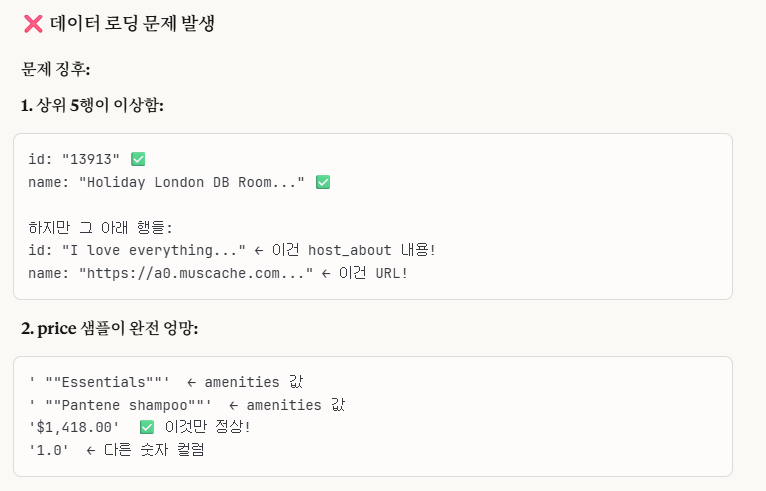

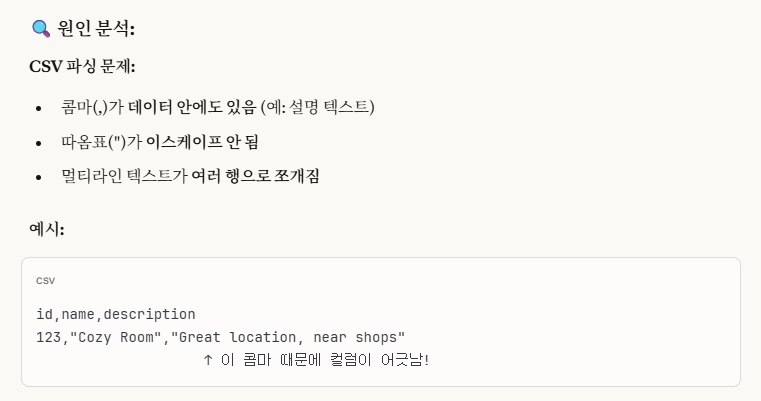

## 해결 방법: CSV 옵션 조정

## 6-1. 데이터 다시 로딩(옵션 강화)

In [18]:
# 6-1. CSV 파싱 옵션 강화하여 재로딩
# 문제: 콤마, 따옴표, 멀티라인 텍스트 때문에 파싱 실패
# 해결: CSV 파서 옵션을 더 정교하게 설정

#cf.) CSV(Comma Seperated Values): 기본적인 구조로 '콤마(,)는 컬럼 구분자' & '줄바꿈은 행 구분자'임.

# 파일 경로 재확인
listings_path_London = os.path.join(data_path,'listings_London.csv.gz')

# 향상된 CSV 옵션으로 다시 로딩
df_listings_fixed_London = (spark.read
    .option("header", "true")  # 첫 행 = 컬럼명
    .option("inferSchema", "true")  # 타입 자동 추론
    .option("compression", "gzip")  # .gz 압축 해제

    # 추가 옵션
    .option("quote", '"') # 따옴표 문자 지정(CSV 표준)
    .option("escape", '"')  # 이스케이프 문자 (따옴표 2개 = 하나의 따옴표)
    .option("multiLine", "true")  # 멀티라인 필드 허용 (느리지만 정확)
    .option("ignoreLeadingWhiteSpace", "true")  # 앞 공백 무시
    .option("ignoreTrailingWhiteSpace", "true")  # 뒤 공백 무시

    # ============================================================
    # 옵션 상세 설명:
    # ============================================================
    #
    # option("quote", '"'): '이 문자로 감싸진 건 하나의 필드야!'라는 의미다.
    #   - CSV에서 필드(csv에서 행과 열이 만나는 하나의 셀(데이터)을 의미함.)를 감싸는 문자 지정
    #   - 작은따옴표 안에 큰따옴표 문자 하나: '"' -> 그래서, ""로 감싸진 건 하나의 필드라고 보는 것이다.
    #   - CSV 예시: "Hello, World","123","Test"
    #   - 큰따옴표로 감싸진 필드 내부의 콤마는 구분자로 취급 안 함
    #
    # option("escape", '"') : CSV 표준 규칙 상, 따옴표(")를 데이터로 쓰려면 2개 연속 사용해야한다. 그래서 이 의미는, '큰 따옴표 2개를 만나면, 실제 데이터로는 1개로 변환해줘.' 라는 의미이다.
    #   - 특수문자를 이스케이프(단어 그대로 '탈출'인데, 특수 문자가 제 기능을 하는 게 아니라 그 기능을 탈출하여 '단순 문자열'로 보이게 하는 것)하는 문자 지정
    #   - CSV 표준: 큰따옴표 2개("") = 실제 큰따옴표 1개(")
    #   - 예시: "Say ""Hello""" → 실제 값: Say "Hello"
    #   - 예시: "He said ""Hi""" → 실제 값: He said "Hi"
    #
    # option("multiLine", "true")
    #   - 한 필드가 여러 줄(행)에 걸쳐 있어도 하나의 필드로 인식
    #   - 사용 예시: description 컬럼에 줄바꿈(\n)이 포함된 경우
    #   - CSV 예시:
    #     "Room 1","Beautiful room
    #              with great view"  ← 2줄이지만 하나의 필드
    #   - ⚠️ 단점: 전체 파일을 메모리에 올려 파싱하므로 느림
    #   - 정확도(true) vs 속도(false) 트레이드오프
    #
    # option("ignoreLeadingWhiteSpace", "true")
    #   - 필드 앞쪽의 공백 문자 제거
    #   - 예시: "  London" → "London"
    #   - 예시: "\tParis" → "Paris" (탭 문자도 제거)
    #
    # option("ignoreTrailingWhiteSpace", "true")
    #   - 필드 뒤쪽의 공백 문자 제거
    #   - 예시: "London  " → "London"
    #   - 예시: "Paris\t" → "Paris" (탭 문자도 제거)
    # ============================================================

    .csv(listings_path_London)
)

print("✅ 향상된 옵션으로 재로딩 완료!")
print(f"총 행 수: {df_listings_fixed_London.count():,}")
print(f"총 열 수: {len(df_listings_fixed_London.columns)}")

✅ 향상된 옵션으로 재로딩 완료!
총 행 수: 96,871
총 열 수: 79


## 6-2. 재로딩 결과 확인

In [19]:
# 6-2. 재로딩 후 데이터 품질 확인
# 제대로 파싱됐는지 확인

# 핵심 컬럼만 선택(동일한 컬럼 리스트)
df_key_fixed_London = df_listings_fixed_London.select(key_columns_London)

print("=" * 80)
print("🔍 재로딩 후 데이터 샘플 (상위 10행):")
print("=" * 80)

# id, name, price, neighbourhood_cleansed만 먼저 확인
df_key_fixed_London.select("id", "name", "price", "neighbourhood_cleansed").show(10, truncate=50) # truncate=50: 앞에서부터 50칸만 보여줌.

# price 컬럼 재확인
print("\n" + "=" * 80)
print("💰 Price 컬럼 샘플 (재로딩 후):")
print("=" * 80)

# NULL이 아닌 price만 선택.(Method Chaining 방식)
price_samples_fixed = (df_key_fixed_London
    .select("price")
    .filter("price IS NOT NULL")  # NULL 제외
    .distinct()  # 중복 제거
    .limit(10)  # 10개만
    .collect())

#위와 같은 방식을 다음과 같이 3개로 나타낼 수 있다.
#
# 1. Method Chaining:
# 여러 메서드를 연속으로 호출
# object.method1().method2().method3()
#
#
# 2. Fluent API / Fluent Interface (유창한 인터페이스)
# 읽기 쉽고 자연스러운 코드 작성 방식
# "마치 문장처럼" 읽힘
#
# df.select("price")      # "price를 선택하고"
#  .filter("price > 0")  # "0보다 큰 것만 필터링하고"
#  .distinct()           # "중복을 제거하고"
#  .limit(10)            # "10개만 제한"
#
#
# 3. Builder Pattern (빌더 패턴)
# 복잡한 객체를 단계적으로 구성
# SparkSession.builder \
#    .appName("MyApp") \
#    .config("key", "value") \
#    .getOrCreate()

for row in price_samples_fixed:
    print(f"  '{row.price}'")


🔍 재로딩 후 데이터 샘플 (상위 10행):
+-----+-------------------------------------------------+-------+----------------------+
|   id|                                             name|  price|neighbourhood_cleansed|
+-----+-------------------------------------------------+-------+----------------------+
|13913|              Holiday London DB Room Let-on going| $70.00|             Islington|
|15400|              Bright Chelsea  Apartment. Chelsea!|$149.00|Kensington and Chelsea|
|17402| Very Central Modern 3-Bed/2 Bath By Oxford St W1|$411.00|           Westminster|
|24328|                 Battersea live/work artist house|   NULL|            Wandsworth|
|36274|Bright 1 bedroom apt off brick lane in Shoreditch|$210.00|         Tower Hamlets|
|36299|              Kew Gardens 3BR house in cul-de-sac|$280.00|  Richmond upon Thames|
|36660|                  You are GUARANTEED to love this| $90.00|              Haringey|
|38605|       SUNNY ROOM PRIVATE BATHROOM PLUS BREAKFAST| $61.00|Hammersmith and Fulh

# 7. 재로딩한 제대로 파싱한 데이터를 활용해서 '타입 변환 & 클렌징'하기

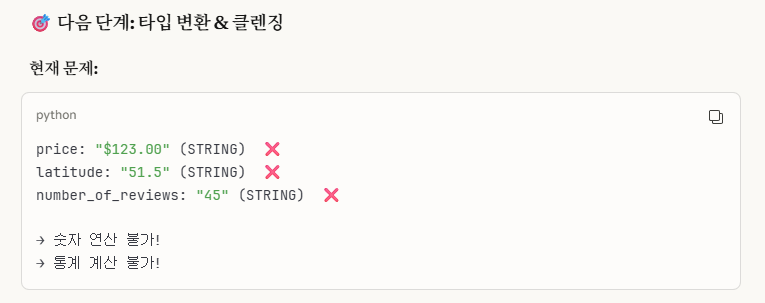

## 7-1. 타입 변환 준비

In [20]:
# 7-1. 타입 변환이 필요한 컬럼 확인
# 어떤 컬럼들을 숫자로 바꿔야 하는지 파악

from pyspark.sql import functions as F # Spark SQL 함수들
from pyspark.sql.types import FloatType, IntegerType # 데이터 타입

# ============================================================
# 변환이 필요한 컬럼들:
#
# 1. 가격 관련 (STRING → FLOAT):
#    - price: "$123.00" → 123.0
#
# 2. 위치 관련 (STRING → FLOAT):
#    - latitude: "51.5" → 51.5
#    - longitude: "-0.12" → -0.12
#
# 3. 수용 인원 (STRING → INT):
#    - accommodates: "4" → 4
#    - bedrooms: "2" → 2
#    - beds: "2" → 2
#
# 4. 예약 관련 (STRING → INT):
#    - minimum_nights: "1" → 1
#    - maximum_nights: "365" → 365
#    - availability_365: "180" → 180
#
# 5. 리뷰 관련 (STRING → INT/FLOAT):
#    - number_of_reviews: "45" → 45 (INT)
#    - review_scores_rating: "4.5" → 4.5 (FLOAT)
#    - review_scores_location: "4.8" → 4.8 (FLOAT)
# ============================================================

print("🔧 타입 변환 대상 컬럼:")
print("\n1. 가격: price")
print("2. 위치: latitude, longitude")
print("3. 수용: accommodates, bedrooms, beds")
print("4. 예약: minimum_nights, maximum_nights, availability_365")
print("5. 리뷰: number_of_reviews, review_scores_rating, review_scores_location")

🔧 타입 변환 대상 컬럼:

1. 가격: price
2. 위치: latitude, longitude
3. 수용: accommodates, bedrooms, beds
4. 예약: minimum_nights, maximum_nights, availability_365
5. 리뷰: number_of_reviews, review_scores_rating, review_scores_location


## 7-2. Price 컬럼 변환(가장 중요!)

In [21]:
# 7-2. Price 컬럼 타입 변환
# "$123.00"(String) → 123.0 (FLOAT) 변환

# price 변환 전 샘플 확인
print("=" * 80)
print("💰 price 변환 전:")
print("=" * 80)
df_key_fixed_London.select("id", "price").show(5)

# 변환 과정:
# Step 1: "$" 제거 → "123.00"
# Step 2: "," 제거 → "123.00" (천 단위 콤마)
# Step 3: FLOAT 변환 → 123.0

# F.regexp_replace(): 정규표현식(말 그대로, 정규(regular,규칙적인/일정한 패턴을 따르는) + 표현식으로, '일정한 규칙/패턴으로 문자열을 표현하는 식'. ex)# "010으로 시작하는 11자리 숫자"라는 '규칙' -> pattern = r'010-\d{4}-\d{4}') 으로 문자 치환
# 문법: regexp_replace(컬럼,'찾을패턴','바꿀내용')
df_cleaned_London = df_key_fixed_London.withColumn( # WithColumn: 새로운 컬럼 추가 or 기존 컬럼 수정하는 함수.
    "price_clean", # 새 컬럼 이름
    F.regexp_replace("price","[$,]","") # $와 , 제거
)

# STRING → FLOAT 변환
# cast(): 데이터 타입 변환
df_cleaned_London = df_cleaned_London.withColumn(
    "price_float", # 변환된 컬럼(새 컬럼)
    F.col("price_clean").cast(FloatType()) # Float으로 변환. # col(): 컬럼 객체 생성
)

# 변환 결과 확인
print("\n" + "=" * 80)
print("💰 price 변환 후:")
print("=" * 80)
df_cleaned_London.select("id", "price", "price_clean", "price_float").show(10)

# 통계로 확인
print("\n" + "=" * 80)
print("📊 변환된 price 통계:")
print("=" * 80)
df_cleaned_London.select("price_float").describe().show()

💰 price 변환 전:
+-----+-------+
|   id|  price|
+-----+-------+
|13913| $70.00|
|15400|$149.00|
|17402|$411.00|
|24328|   NULL|
|36274|$210.00|
+-----+-------+
only showing top 5 rows

💰 price 변환 후:
+-----+-------+-----------+-----------+
|   id|  price|price_clean|price_float|
+-----+-------+-----------+-----------+
|13913| $70.00|      70.00|       70.0|
|15400|$149.00|     149.00|      149.0|
|17402|$411.00|     411.00|      411.0|
|24328|   NULL|       NULL|       NULL|
|36274|$210.00|     210.00|      210.0|
|36299|$280.00|     280.00|      280.0|
|36660| $90.00|      90.00|       90.0|
|38605| $61.00|      61.00|       61.0|
|38610|$340.00|     340.00|      340.0|
|38995| $49.00|      49.00|       49.0|
+-----+-------+-----------+-----------+
only showing top 10 rows

📊 변환된 price 통계:
+-------+-----------------+
|summary|      price_float|
+-------+-----------------+
|  count|            61963|
|   mean|229.9169827154915|
| stddev|4437.589295624414|
|    min|              7.0|
|    

# 8. 나머지 컬럼들도 타입 변환하기

## 8-1. 나머지 컬럼들도 타입 전부 다 변환하기

In [22]:
# 8-1. 모든 숫자 컬럼 타입 변환 -> 아마 칼럼 전부 다는 아니고, 일부분일 거 같음.
# 한 번에 여러 칼럼 변환하기

from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, IntegerType

# 변환 전략:
# 1. 위치 정보: latitude, longitude → FLOAT
# 2. 수용 정보: accommodates, bedrooms, beds → INT
# 3. 예약 정보: minimum_nights, maximum_nights, availability_365 → INT
# 4. 리뷰 정보: number_of_reviews → INT, review_scores → FLOAT

# 기존 df_cleaned_London에 계속 추가
df_final_London = df_cleaned_London

# 1. 위치 정보 변환(latitude,longitude)
# 이미 숫자 형태(소수점 포함)이므로 바로 Float으로 변환

df_final_London = (df_final_London
    .withColumn("latitude_float",F.col("latitude").cast(FloatType()))
    .withColumn("longitude_float", F.col("longitude").cast(FloatType()))
)

# 2. 수용 정보 변환 (accommodates, bedrooms, beds)
# 정수 형태이므로 INT 변환

df_final_London = (df_final_London
    .withColumn("accommodates_int", F.col("accommodates").cast(IntegerType()))
    .withColumn("bedrooms_int", F.col("bedrooms").cast(IntegerType()))
    .withColumn("beds_int", F.col("beds").cast(IntegerType()))
)


# 3. 예약 정보 변환 (minimum_nights, maximum_nights, availability_365)
# 날짜/일수는 정수 → INT

df_final_London = (df_final_London
    .withColumn("minimum_nights_int", F.col("minimum_nights").cast(IntegerType()))
    .withColumn("maximum_nights_int", F.col("maximum_nights").cast(IntegerType()))
    .withColumn("availability_365_int", F.col("availability_365").cast(IntegerType()))
)

# 4. 리뷰 정보 변환 (number_of_reviews, review_scores)
# number_of_reviews: 정수 → INT
# review_scores: 평점은 소수점 (예: 4.5) → FLOAT

df_final_London = (df_final_London
    .withColumn("number_of_reviews_int", F.col("number_of_reviews").cast(IntegerType()))
    .withColumn("review_scores_rating_float", F.col("review_scores_rating").cast(FloatType()))
    .withColumn("review_scores_location_float", F.col("review_scores_location").cast(FloatType()))
)




In [23]:
# 변환 결과 확인
print("=" * 80)
print("✅ 타입 변환 완료!")
print("=" * 80)

# 스키마 확인
print("\n📋 변환된 컬럼 스키마:")
df_final_London.select(
    "price_float",
    "latitude_float",
    "accommodates_int",
    "bedrooms_int",
    "beds_int",
    "number_of_reviews_int",
    "review_scores_rating_float"
).printSchema() # Dataframe 스키마(schema)(데이터의 구조 정보) 출력 -> 각 컬럼의 이름,타입,Null 허용 여부 등 표시

# 샘플 데이터
print("\n" + "=" * 80)
print("🔍 변환된 데이터 샘플:")
print("=" * 80)
df_final_London.select(
    "id",
    "price_float",
    "accommodates_int",
    "bedrooms_int",
    "beds_int",
    "number_of_reviews_int"
).show(10) # 상위 10개만

# bedrooms, beds가 실제로 정수인지 확인
print("\n" + "=" * 80)
print("🔍 bedrooms 실제 값 확인:")
print("=" * 80)
df_final_London.select("bedrooms", "bedrooms_int").distinct().orderBy("bedrooms_int").show(10)

print("\n✅ 모든 타입 변환 완료!")

✅ 타입 변환 완료!

📋 변환된 컬럼 스키마:
root
 |-- price_float: float (nullable = true)
 |-- latitude_float: float (nullable = true)
 |-- accommodates_int: integer (nullable = true)
 |-- bedrooms_int: integer (nullable = true)
 |-- beds_int: integer (nullable = true)
 |-- number_of_reviews_int: integer (nullable = true)
 |-- review_scores_rating_float: float (nullable = true)


🔍 변환된 데이터 샘플:
+-----+-----------+----------------+------------+--------+---------------------+
|   id|price_float|accommodates_int|bedrooms_int|beds_int|number_of_reviews_int|
+-----+-----------+----------------+------------+--------+---------------------+
|13913|       70.0|               1|           1|       1|                   55|
|15400|      149.0|               2|           1|       1|                   97|
|17402|      411.0|               6|           3|       3|                   56|
|24328|       NULL|               2|           1|    NULL|                   95|
|36274|      210.0|               4|           1|   

※p.s) Claude와 phase 5-2 - Spark(빅데이터 분산하여 Pandas에서 활용하지 못하는 작업하기)에 대한 학습을 하려는 도중에,

지금까지 우리가 한 작업들을 돌아봤을 때, **'도대체 우리는 빅데이터를 다룬 게 맞으며, Pandas가 할 수 없는 Spark만이 할 수 있는 작업을 한 게 맞는가?'**라는 의심이 들었다.

결과는 역시나.... '아니다(No)'였다.



---
돌이켜보니, 우리는 고작 5GB+ 정도의 데이터셋만을 활용했고(빅데이터는 100GB~10TB+), 실무에서는 cluster 방식으로 여러 대의 서버에서 동시 실행하지만, 우리는 현실적으로 1대의 로컬 PC(Colab (local[*]))에서 진행할 수 밖에 없는 환경이었다.



---
하지만, 그렇다고 해서 완전히 말짱 도루묵은 아니다.

우리가 지금까지 한 것 중에 Spark스러운 작업은 다음과 같다.



1.   Lazy Evaluation(지연 실행)


```
# 우리가 한 것:
df = spark.read.csv(...)  # 실행 안 됨
df = df.filter(...)       # 실행 안 됨
df.show()                 # 여기서 실행

# Spark스러움: ✅
# 체감했냐: ❌ (데이터 작아서 차이 없음)
# 가치: 5점 (개념만 배움)


```
->pandas는 각 줄을 바로 실행한다고 함.



```
import pandas as pd

# 메서드 체이닝: 가능 ✅
df = (pd.read_csv("data.csv")     # 실행됨! 즉시!
    .query("price > 0")            # 실행됨! 즉시!
    .groupby("city")               # 실행됨! 즉시!
    .size())                       # 실행됨! 즉시!

# 지연 실행: 불가능 ❌
→ 각 줄마다 바로 실행됨
→ 메모리에 바로 로딩됨
```




2. Spark Session 초기화

3. Spark DataFrame 생성

4. CSV 파싱 옵션

5. DataFrame 변환/조회



---
※결론)
이번 colab 학습 프로젝트는 제대로 망쳤다.



```
### **사용 안 한 Spark 기능:**

❌ .filter() - 조건 필터링
❌ .groupBy().agg() - 집계
❌ .join() - 테이블 조인
❌ Window Functions - 순위, 누적
❌ .cache(), .persist() - 메모리 최적화
❌ .repartition() - 파티셔닝
❌ broadcast() - Join 최적화
❌ Spark SQL
```

이 작업들을 하고 싶지만,
현재 작업 환경 상 못하는 게 너무 아쉽다...

다음에 기회되면 하고 싶다..










